# Segmentation and regionprops

### Prueba con grano de polen

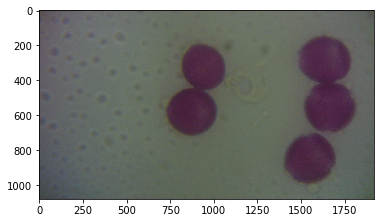

In [1]:
import skimage
skimage.__version__
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

image = plt.imread('Muestra6.jpg')
plt.imshow(image);

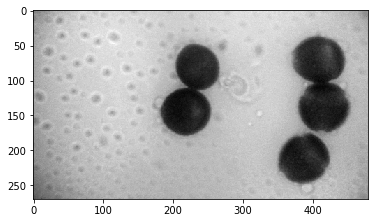

In [2]:
import cv2
from skimage.color import rgb2gray
image=cv2.resize(image,(480,270))#resize image
gray = rgb2gray(image)
from skimage import util; 
image = util.img_as_float(gray);
plt.imshow(image, cmap='gray');

C:\Users\Angel\Anaconda3\envs\tensorflowGPU\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


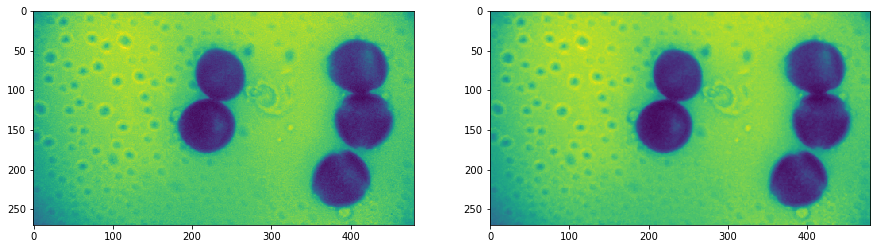

In [3]:
from skimage import filters

image_denoised = filters.median(image, selem=np.ones((2, 2)))

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.imshow(image)
ax1.imshow(image_denoised);

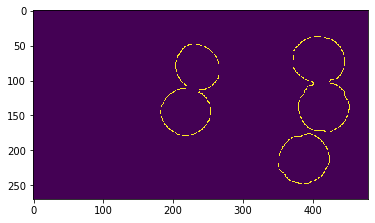

In [4]:
from skimage import feature
edges = skimage.feature.canny(image, sigma=2)

plt.imshow(edges);

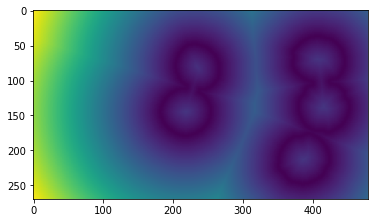

In [5]:
from scipy.ndimage import distance_transform_edt
dt = distance_transform_edt(~edges)

plt.imshow(dt);

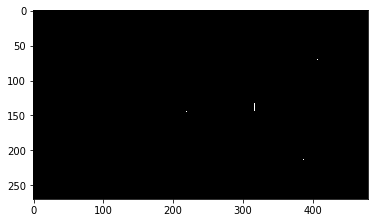

In [6]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)
plt.imshow(local_max, cmap='gray');

In [7]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=5)
peak_idx[:5]

array([[213, 387],
       [145, 219],
       [144, 317],
       [143, 317],
       [142, 317]], dtype=int64)

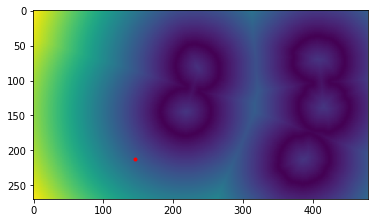

In [8]:
plt.plot(peak_idx[1], peak_idx[0], 'r.')
plt.imshow(dt);

In [9]:
from skimage import measure

markers = measure.label(local_max)

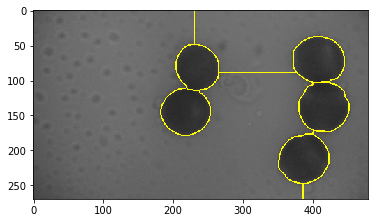

In [10]:
from skimage import morphology, segmentation

labels = morphology.watershed(-dt, markers)
plt.imshow(segmentation.mark_boundaries(image, labels));

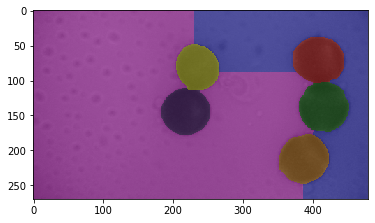

In [11]:
from skimage import color
plt.imshow(color.label2rgb(labels, image=image));

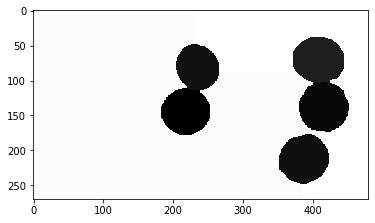

In [12]:
plt.imshow(color.label2rgb(labels, image=image, kind='avg'), cmap='gray');

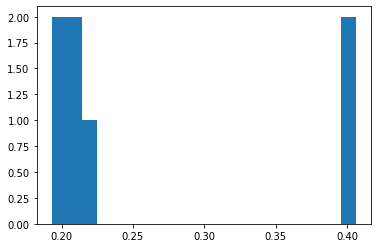

In [13]:
regions = measure.regionprops(labels, intensity_image=image)
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20);

In [14]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)

region_means = np.array(region_means).reshape(-1, 1)
model.fit(np.array(region_means).reshape(-1, 1))
print(model.cluster_centers_)

[[0.20520244]
 [0.4050993 ]]


In [15]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([0, 1, 0, 1, 0, 0, 0])

In [16]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

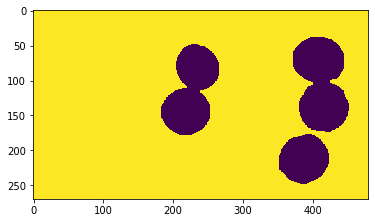

In [17]:
plt.imshow(classified_labels);

In [18]:
print(classified_labels)
classified_labels.shape

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


(270, 480)

In [19]:
cv2.imwrite('classified_labels.jpg', classified_labels)

True

In [ ]:
plt.imshow(color.label2rgb(classified_labels, image=image));

In [ ]:
plt.imshow(color.label2rgb(classified_labels, image=image, kind='avg'), cmap='gray');

In [20]:
def findSignificantContour(edgeImg):
    import cv2
    image, contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
    # From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])

    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour


In [20]:
classified_labels_resize = plt.imread('classified_labels.jpg')
#inter = cv2.INTER_AREA
classified_labels_resize=cv2.resize(classified_labels_resize, (1920,1080))#resize image
mask2 = classified_labels_resize.astype('uint8')

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


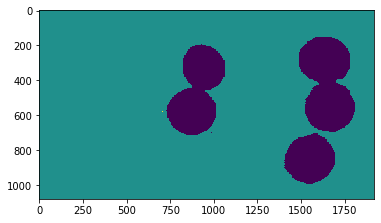

In [21]:
plt.imshow(classified_labels_resize);
print(classified_labels_resize)

In [30]:
classified_labels_resize.shape

(1080, 1920)

In [27]:
#contour2 = findSignificantContour(mask2)
#mask3 = np.zeros_like(mask2)
#cv2.fillPoly(mask3, [contour2], 255)

# blended alpha cut-out
#mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
#mask4 = cv2.GaussianBlur(mask3, (3, 3), 0)
alpha = classified_labels_resize.astype(float) * 1.1  # making blend stronger
alpha[mask3 > 0] = 255
alpha[alpha > 255] = 255
alpha = alpha.astype(float)

####Foreground
src = cv2.imread('Muestra6.jpg', 1)
foreground = np.copy(src).astype(float)
foreground[mask4 == 0] = 0

####Background
background = np.ones_like(foreground, dtype=float) * 255

cv2.imwrite('foreground.png', foreground)
cv2.imwrite('background.png', background)
cv2.imwrite('alpha.png', alpha)

True

In [ ]:
image = plt.imread('Muestra6.jpg')
Resultado = np.zeros_like(image)
for height in classified_labels_resize:
    for width in height:
        if width == 1:
            Resultado[height][width]=0

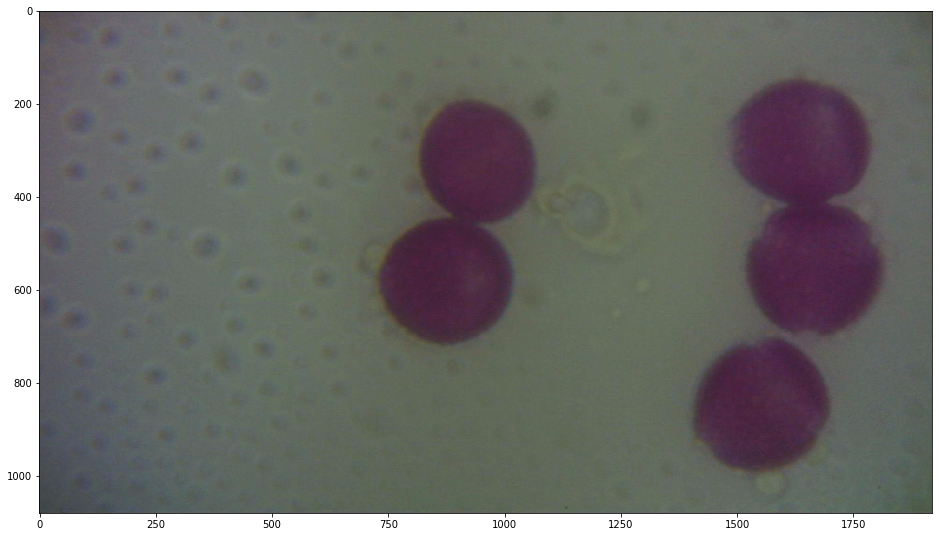

In [28]:
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha / 255.0
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
# Add the masked foreground and background.
cutout = cv2.add(foreground, background)

cv2.imwrite('polen_cutout.jpg', cutout)
cut=plt.imread('polen_cutout.jpg')
plt.figure(figsize=(16,11))
plt.imshow(cut);

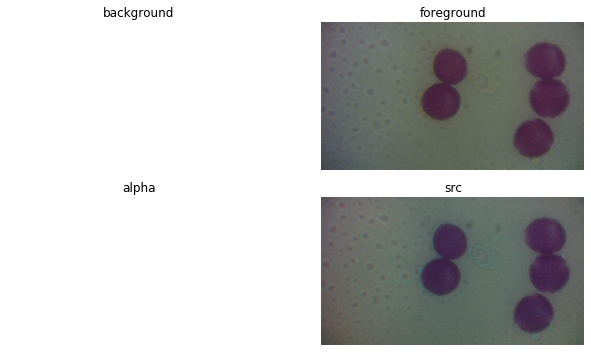

In [29]:
foreg = plt.imread('foreground.png')
backg = plt.imread('background.png')
a = plt.imread('alpha.png')


# Show the images.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(backg)
ax[0].set_title('background')

ax[1].imshow(foreg)
ax[1].set_title('foreground')

ax[2].imshow(a)
ax[2].set_title('alpha')

ax[3].imshow(src)
ax[3].set_title('src')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()